<a href="https://colab.research.google.com/github/sunilh1/Cancer-Prediction-Genomes-AzureML/blob/ML_changes/Project%20Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import precision_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

## Loading The Data

In [2]:
# Pan Cancer dataframe
pan_cancer_df = pd.DataFrame()

# Cancer types
cancers = ['kich', 'acc', 'blca', 'brca', 'cesc', 'esca', 'kirk', 'laml', 'lgg', 'lich', 'ov', 'paad', 'prad', 'read', 'tgct', 'thca']
# cancers_ = ['luad', 'ucec', 'coad', 'skcm']

# Import data
# 100%
for cancer in cancers:
  data = pd.read_csv(f'/content/{cancer}.csv')
  data['project_id'] = cancer.upper()

  pan_cancer_df = pd.concat([pan_cancer_df, data], ignore_index=True)

# 50%
for cancer in cancers_:
  data = pd.read_csv(f'/content/{cancer}.csv')
  data['project_id'] = cancer.upper()
  rows_fifty_perc = int(0.5 * len(data))
  data_fifty_perc = data.sample(n=rows_fifty_perc, random_state=42)
  pan_cancer_df = pd.concat([pan_cancer_df, data_fifty_perc], ignore_index=True)


# 4. Getting Basic Understanding of The Data

### 4.1 Seeing the Data and Shape


# Getting Basic Understanding of The Data

### Seeing the Data and Shape

In [3]:
# Shape
pan_cancer_df.shape

(1573235, 37)

### Dataset Info

In [4]:
# Dataframe info
pan_cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573235 entries, 0 to 1573234
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   #"chrom"                     1573235 non-null  object 
 1   chromStart                   1573235 non-null  int64  
 2   chromEnd                     1573235 non-null  int64  
 3   name                         1573235 non-null  object 
 4   score                        1573235 non-null  int64  
 5   strand                       1573235 non-null  object 
 6   thickStart                   1573235 non-null  int64  
 7   thickEnd                     1573235 non-null  int64  
 8   reserved                     1573235 non-null  object 
 9   blockCount                   1573235 non-null  int64  
 10  blockSizes                   1573235 non-null  int64  
 11  chromStarts                  1573235 non-null  int64  
 12  sampleCount                  1573235 non-n

### Changing the datatype for memomry optimization

In [5]:
### Changing the datatype for memomry optimization
columns = pan_cancer_df.select_dtypes(exclude=[object, float]).columns
pan_cancer_df[columns] = pan_cancer_df[columns].astype('int32')

###  Number of Unique Values In Each Column

In [6]:
pd.DataFrame(pan_cancer_df.nunique(), columns=['No. of Unique Values']).sort_values(by = 'No. of Unique Values') # Getting number of unique values in each column

,No. of Unique Values
chromStarts,1
strand,1
blockCount,1
reserved,1
Variant_Type,3
Variant_Classification,18
project_id,20
"#""chrom""",24
dbSNP_Val_Status,43
score,47


### Missing Values In Each Column

In [7]:
pd.DataFrame(pan_cancer_df.isna().sum(), columns=['Missing Values'])

,Missing Values
"#""chrom""",0
chromStart,0
chromEnd,0
name,0
score,0
strand,0
thickStart,0
thickEnd,0
reserved,0
blockCount,0


### Renaming Columns For Better Understanding

In [8]:
# Columns to lowercase
pan_cancer_df.columns = pan_cancer_df.columns.str.lower()

# Rename columns
pan_cancer_df.rename(columns={'#"chrom"':'chrom', 'project_id':'cancer_type', 'variant_classification':'variant', 'matched_norm_sample_barcode':'barcode'}, inplace=True)

In [9]:
# Gender columns cleaning

pan_cancer_df['gender'] = pan_cancer_df['gender'].apply(lambda x: x[:5] if x.startswith('m') else x[:6])
pan_cancer_df['gender'].replace({'--' : None, '--,fem':'female', '--,mal':'male', '--,--':None, 'male,' : 'male'}, inplace = True)

In [10]:
pan_cancer_df['gender'].unique()

array(['male', 'female', None], dtype=object)

# Data Analysis
### Target Variable Distribution



```
UCEC - Uterine Corpus Endometrial Carcinoma
SKCM - Skin Cutaneous Melanoma
BLCA - Bladder Urothelial Carcinoma         
COAD - Colon Adenocarcinoma                 
BRCA - Breast Invasive Carcinoma            
LUAD - Lung Adenocarcinoma                  
CESC - Cervical and Endocervical Cancer     
OV   - Ovarian Serous Cystadenocarcinoma    
READ - Rectum Adenocarcinoma                
LICH - Liver Hepatocellular Carcinoma       
ESCA - Esophageal Carcinoma                 
LGG  - Brain Lower Grade Glioma             
PAAD - Pancreatic Adenocarcinoma            
PRAD - Prostate Adenocarcinoma              
KIRK - Kidney Renal Clear Cell Carcinoma    
ACC  - Adrenocortical Carcinoma             
THCA - Thyroid Carcinoma                    
LAML - Acute Myeloid Leukemia               
TGCT - Testicular Germ Cell Tumors          
KICH - Kidney Chromophobe

```

In [11]:
target = 'cancer_type'

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

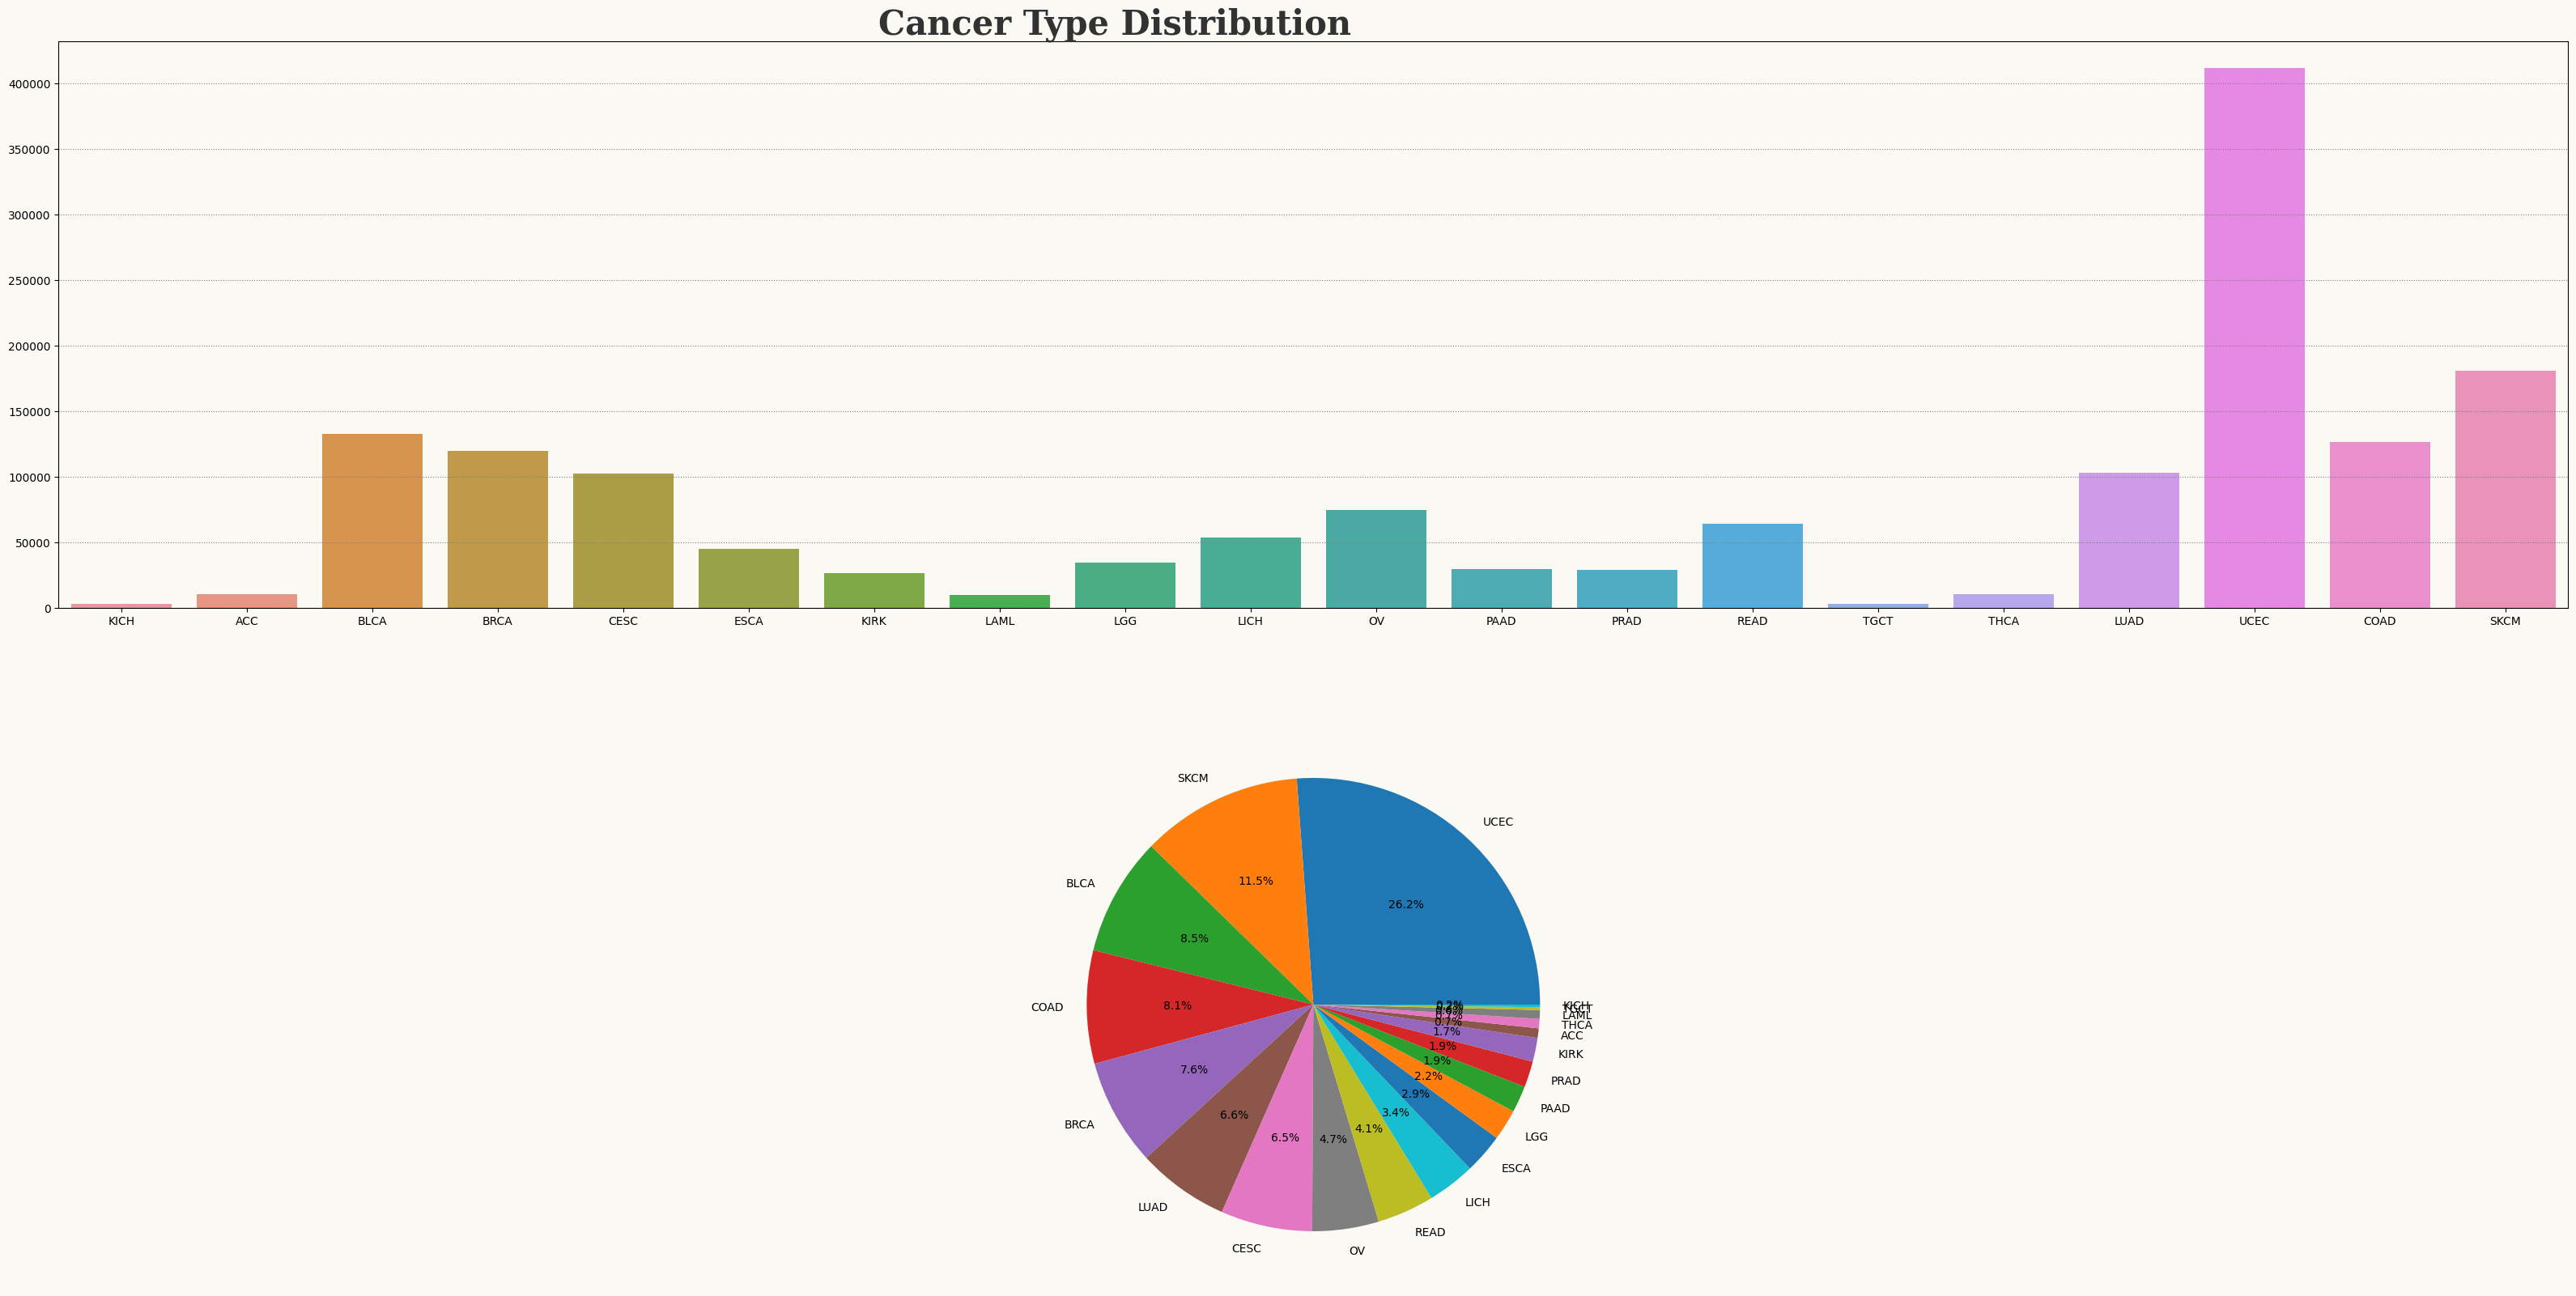

In [39]:
fig = plt.figure(figsize = (40, 20)) # Setting the figure size
gs = fig.add_gridspec(2, 1) # Creating 2 subplots inside the figure

background_color = "#faf9f4" # Storing the background color
# colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"] # Storing the color palette

fig.patch.set_facecolor(background_color) # setting facecolor for the graph

# Fig 1 ---> Here I am overlapping kdeplot and histplot to show the distribution of target variable

ax0 = fig.add_subplot(gs[0, 0]) # Selecting the subplot for first figure
ax0.set_facecolor(background_color) # Setting the facecolor

ax0.grid(color='gray', linestyle=':', axis='y') # Setting the grid style
sns.countplot(data = pan_cancer_df, x = target, ax = ax0) # plotting the kdeplot


ax0.set_xlabel("") # Setting xlable as None
ax0.set_ylabel("") # Setting ylable as None


# Fig 2
ax1 = fig.add_subplot(gs[1, 0]) # Selecting the subplot for second figure
ax1.set_facecolor(background_color) # Setting the facecolor

pan_cancer_df[target].value_counts().plot.pie(autopct = '%1.1f%%', ax = ax1) # plotting the boxplot
ax1.set_xlabel("")# Setting xlable as None
ax1.set_ylabel("")# Setting ylable as None

_ = plt.title('Cancer Type Distribution',fontsize=30, y = 2.2, x = 0.15, fontweight='bold', fontfamily='serif', color="#323232") # Setting the title for the entire plot

In [13]:
# Drop based on null values
pan_cancer_df.drop(columns=['dbsnp_rs', 'dbsnp_val_status', 'days_to_death', 'cigarettes_per_day', 'weight', 'alcohol_history', 'alcohol_intensity', 'years_smoked', 'height', 'ethnicity', 'bmi'], inplace=True)

# Drop based on insignificance
pan_cancer_df.drop(columns=['case_id', 'reserved', 'blockcount', 'score', 'strand', 'chromstarts', 'samplecount', 'tumor_sample_barcode', 'entrez_gene_id', 'barcode'], inplace=True)


## Univariate Analysis

In [14]:
cat_cols = ['chrom', 'variant', 'variant_type', 'gender']
num_cols = [col for col in pan_cancer_df.columns if col not in [target, 'name', 'hugo_symbol', 'reference_allele', 'tumor_seq_allele1', 'tumor_seq_allele2', 'barcode'] + cat_cols]

### Numberical Variables Analysis

In [15]:
num_cols

['chromstart', 'chromend', 'thickstart', 'thickend', 'blocksizes', 'freq']

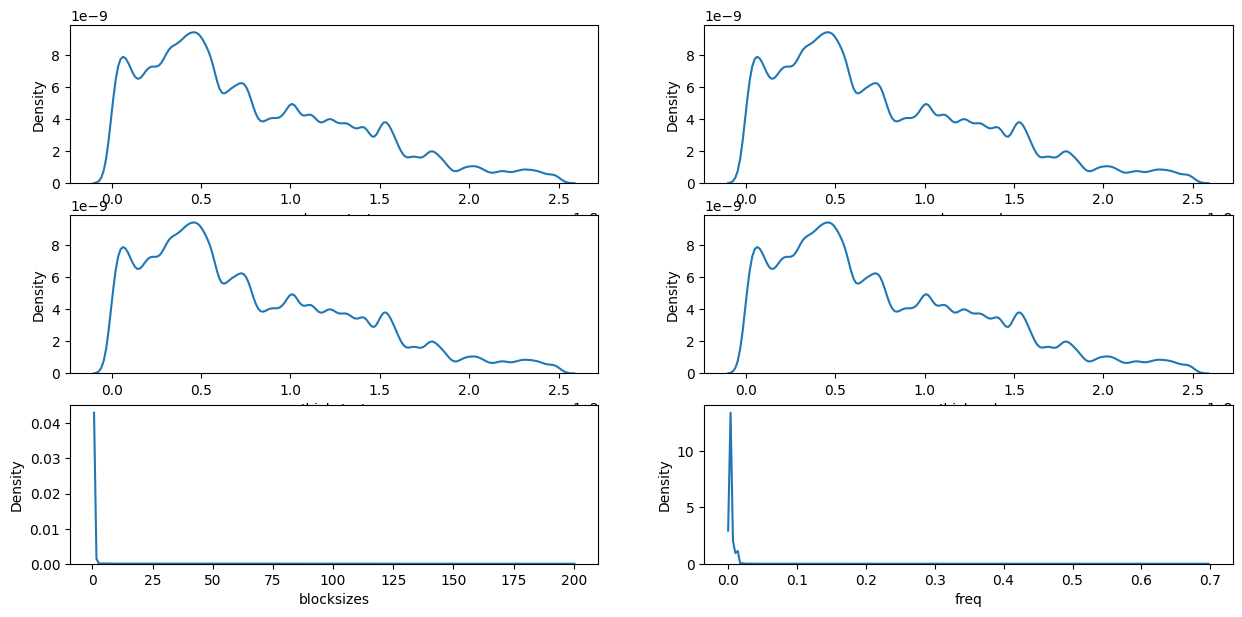

In [104]:
f, ax = plt.subplots(3, 2,figsize = (15, 7))
axx = ax.flatten()
plt.ticklabel_format(style = 'plain')
for index, column in enumerate(num_cols):
    plt.ticklabel_format(style = 'plain')
    sns.kdeplot(pan_cancer_df[column], ax = axx[index])
    plt.ticklabel_format(style = 'plain')

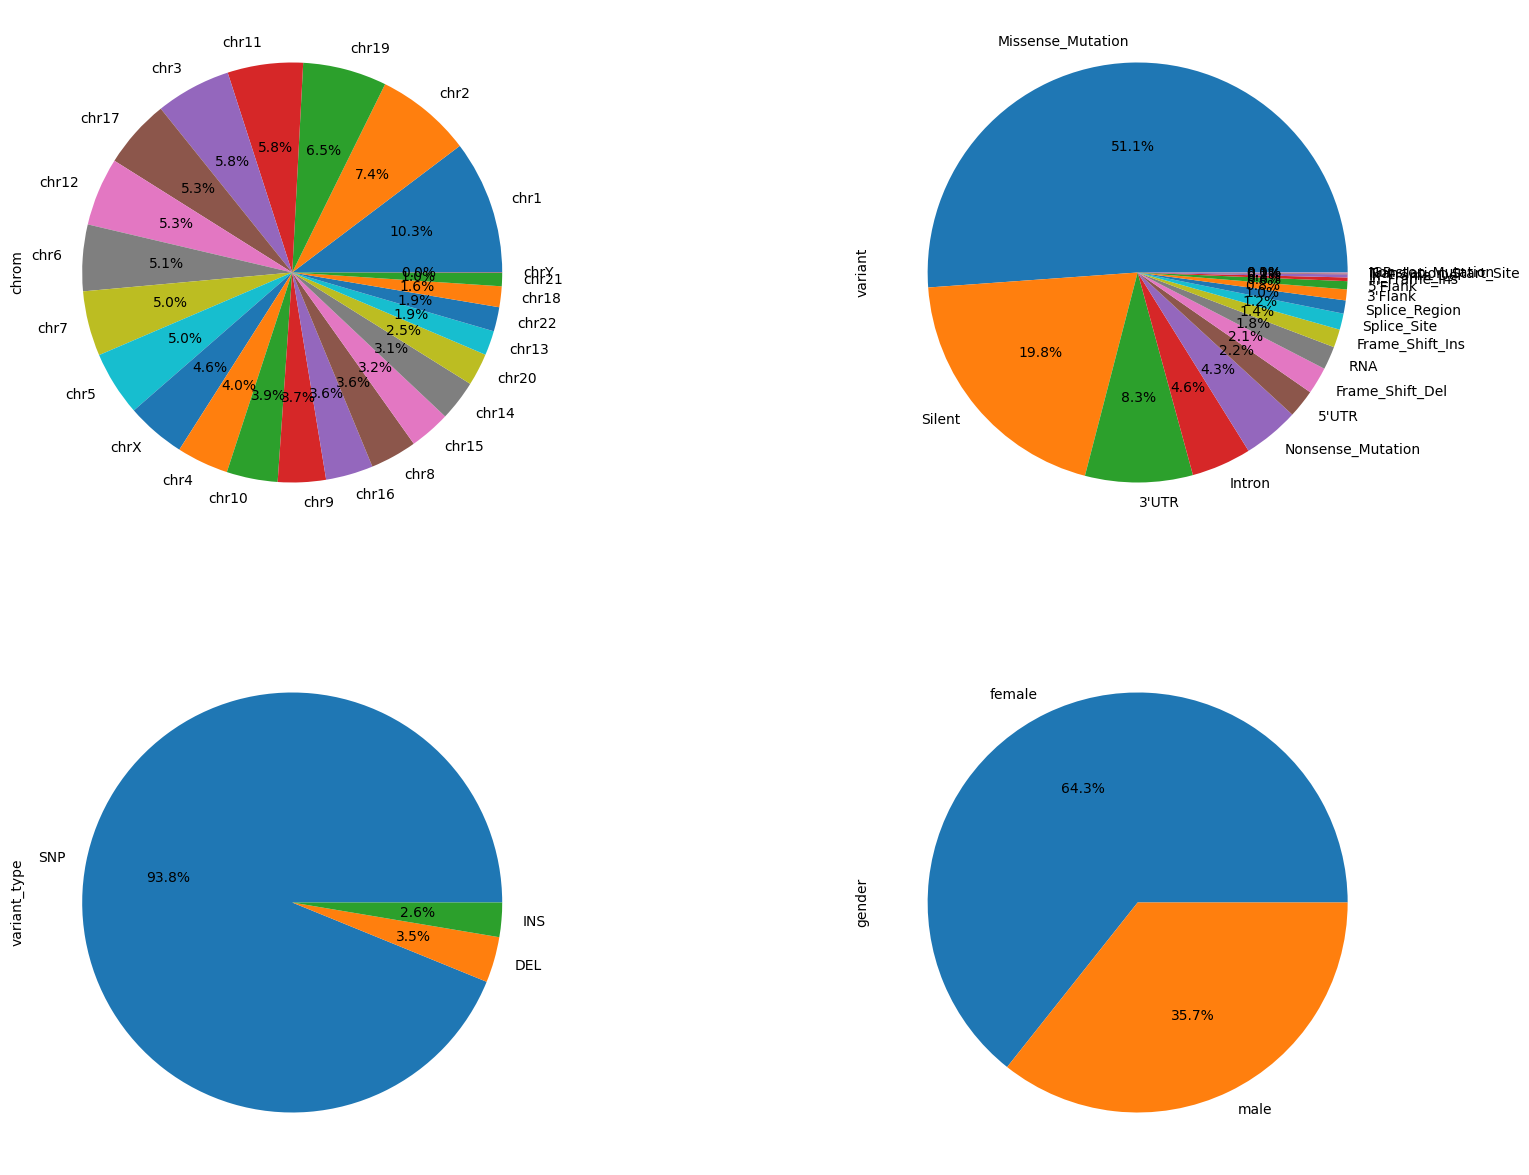

In [107]:
### Categorical Variable Analysis
f, ax = plt.subplots(2, 2,figsize = (20, 15))
axx = ax.flatten()

index = 0
for column in cat_cols:
    # train[column].value_counts().plot(kind='pie', ax = axx[index], title=column, autopct='%.0f', fontsize=12)
    pan_cancer_df[column].value_counts().plot.pie(autopct = '%1.1f%%', ax = axx[index])
    index+=1

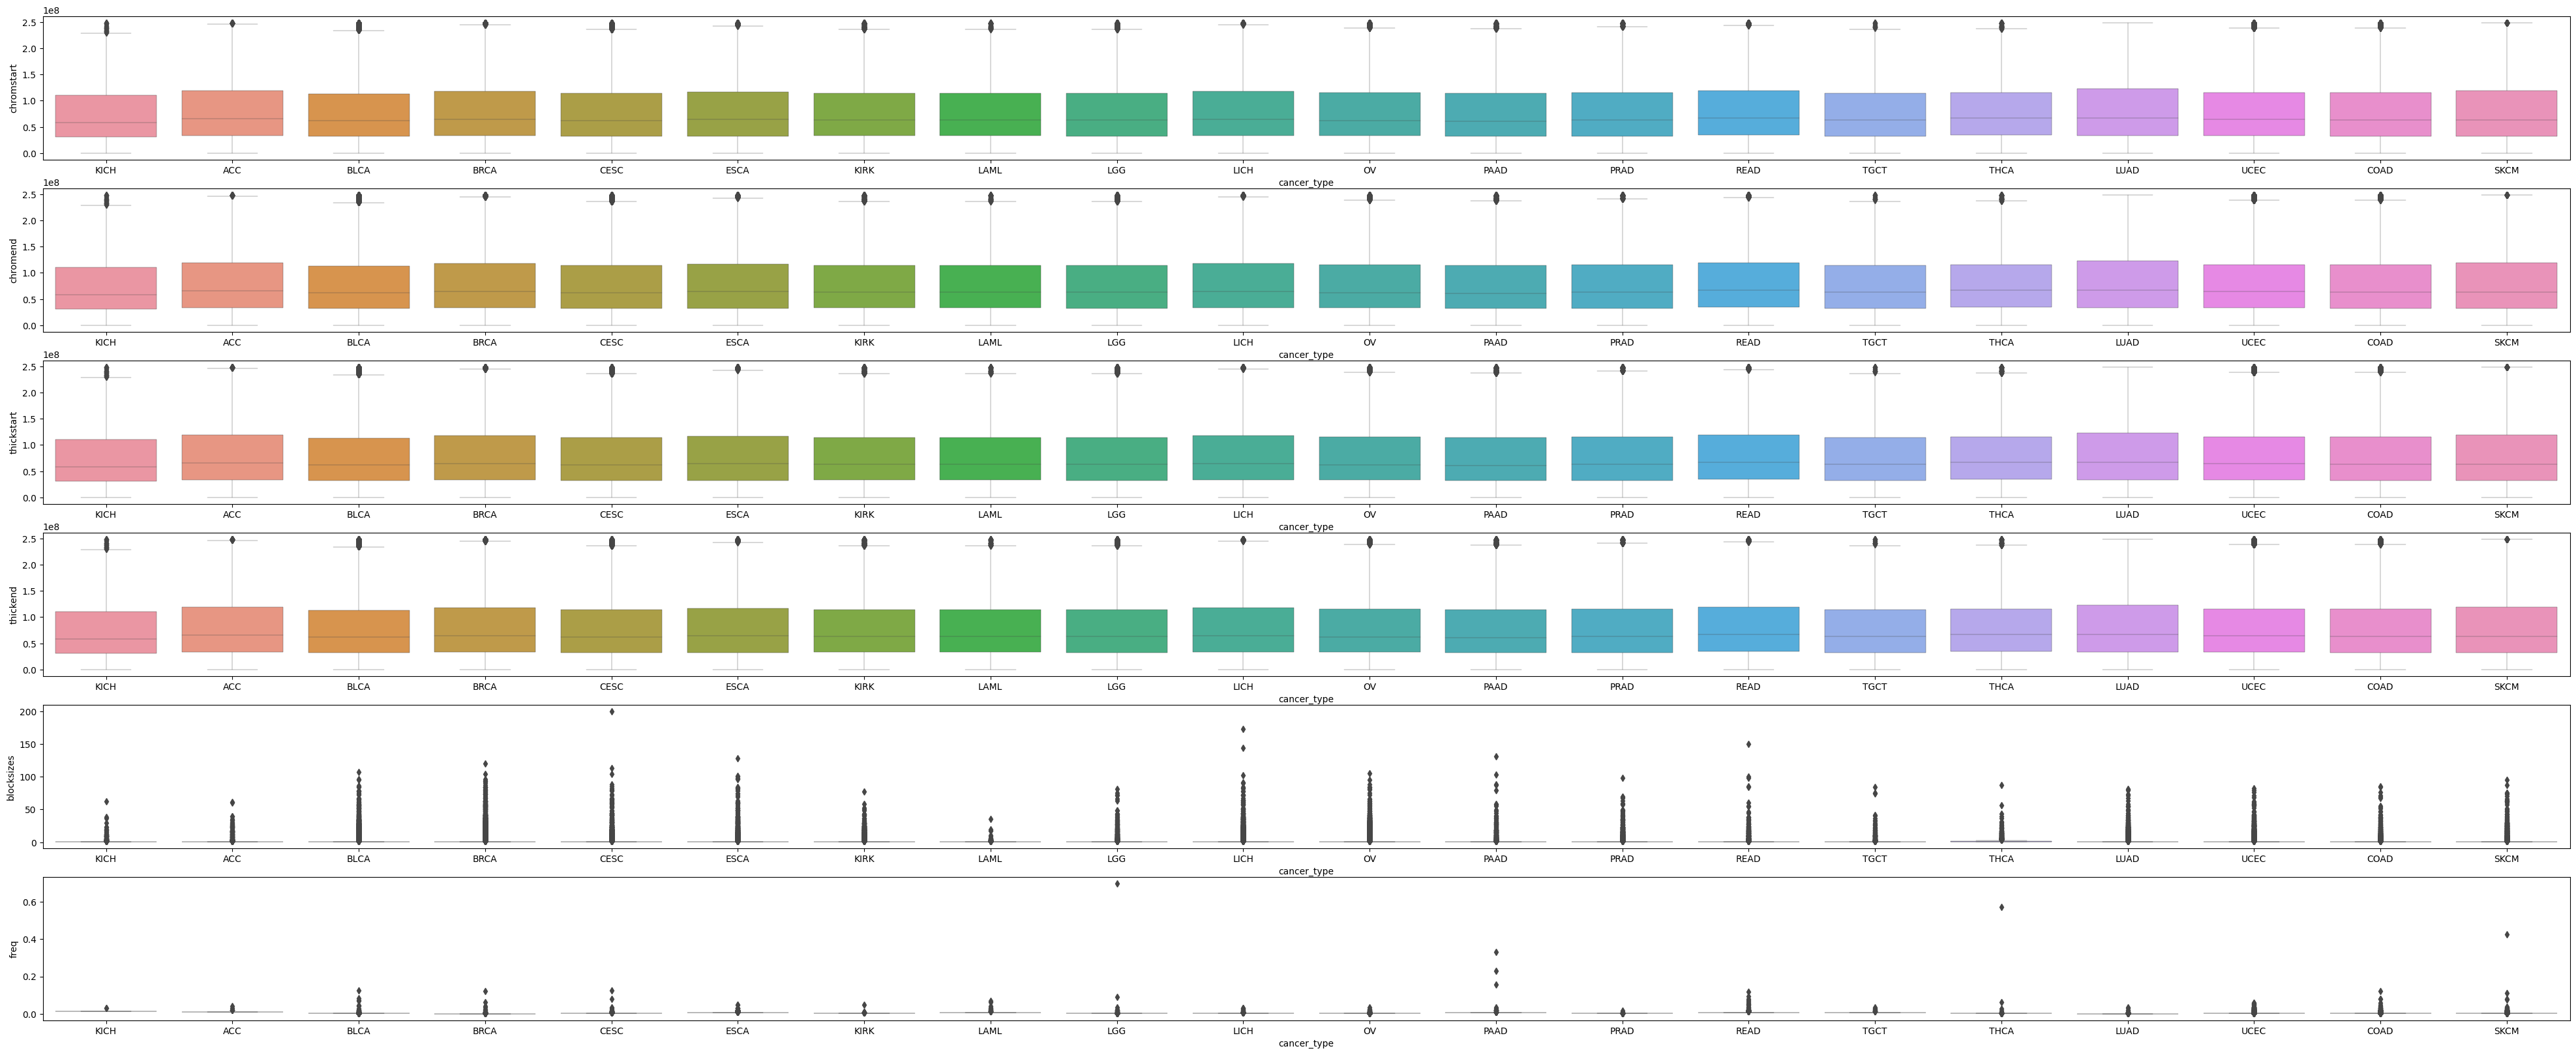

In [114]:
## Bi-Variate Analysis
f, ax = plt.subplots(6, 1,figsize = (50, 20))
axx = ax.flatten()
for index, column in enumerate(num_cols):
    sns.boxplot(data = pan_cancer_df, y=column, linewidth=0.3, zorder=3, ax = axx[index], x = target)


<Axes: >

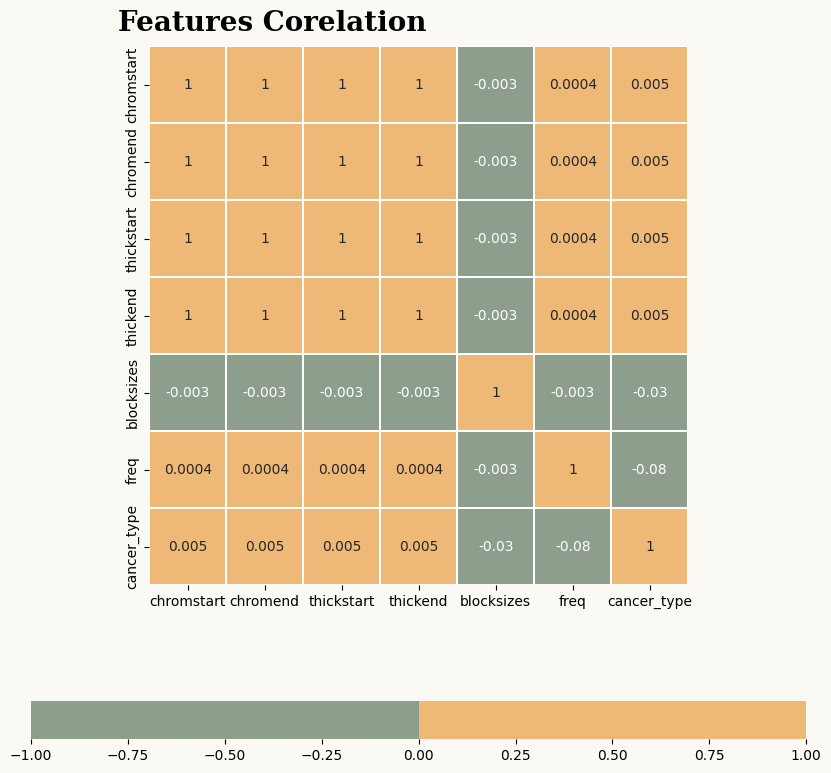

In [127]:
## Co-relation Analysis
fig = plt.figure(figsize = (10, 10))
gs = fig.add_gridspec(1, 1)

ax0 = fig.add_subplot(gs[0, 0])


background_color = "#faf9f4"
fig.patch.set_facecolor(background_color) # figure background color
_ = ax0.set_facecolor(background_color) # axes background color

ax0.text(-0.4, -0.2, 'Features Corelation',  fontsize=20, fontweight='bold', fontfamily='serif')
le = LabelEncoder()
pan_cancer_df[target] = le.fit_transform(pan_cancer_df[target])

cols = num_cols + [target]
sns.heatmap(pan_cancer_df[cols].corr(), ax=ax0, linewidths=.1, vmin=-1, vmax=1, annot=True, square=True,
            cbar_kws={"orientation": "horizontal"}, cbar=True, cmap=["#8d9e8c", "#eeb977"], fmt='.1g', )

### Outlier Analysis

In [ ]:
## Calculate the IQR for the 'freq' column
#Q1 = pan_cancer_df['freq'].quantile(0.25)
#Q3 = pan_cancer_df['freq'].quantile(0.75)
#IQR = Q3 - Q1
#
## Define the lower and upper bounds
#lower_bound = Q1 - 1.5 * IQR
#upper_bound = Q3 + 1.5 * IQR
#
## Filter the DataFrame to remove outliers
#pan_cancer_df = pan_cancer_df[(pan_cancer_df['freq'] >= lower_bound) & (pan_cancer_df['freq'] <= upper_bound)]

In [ ]:
## Calculate the IQR for the 'freq' column
#Q1 = pan_cancer_df['chromstart'].quantile(0.25)
#Q3 = pan_cancer_df['chromstart'].quantile(0.75)
#IQR = Q3 - Q1
#
## Define the lower and upper bounds
#lower_bound = Q1 - 1.5 * IQR
#upper_bound = Q3 + 1.5 * IQR
#
## Filter the DataFrame to remove outliers
#pan_cancer_df = pan_cancer_df[(pan_cancer_df['chromstart'] >= lower_bound) & (pan_cancer_df['chromstart'] <= upper_bound)]

In [ ]:
## Create a boxplot for the 'freq' column
#plt.figure(figsize=(8, 6))
#sns.boxplot(data=pan_cancer_df, y='chromend')
#plt.title('Boxplot of freq Column')
#plt.show()

In [ ]:
## Insights

## Data Preprocessing

In [16]:
## Data Preprocessing
# Label encoding
le = LabelEncoder()

# Iterate through columns and apply label encoding
for column in pan_cancer_df.columns:
    if pan_cancer_df[column].dtype == 'object':
        pan_cancer_df[column] = le.fit_transform(pan_cancer_df[column])

### Test/Train split

In [17]:
features = [col for col in pan_cancer_df.columns if col not in [target]]

In [18]:
 X_train, X_test, y_train, y_test = train_test_split(pan_cancer_df[features], pan_cancer_df[target], test_size=0.2, random_state=42)

### Machine Learning Modelling

In [ ]:
# ## LGBM Classifier
# lgbm = LGBMClassifier(random_state=1, force_col_wise=True, max_depth=6, num_leaves = 72)

# lgbm.fit(X_train, y_train)

# preds = lgbm.predict(X_test)
# preds = preds

# precision = precision_score(y_test, preds, average = 'micro')
# print(f'Precision is : {precision}')
# precision = precision_score(y_test, preds, average = 'macro')
# print(f'Precision is : {precision}')

In [32]:
## Random Forest
rf = RandomForestClassifier(n_estimators = 10, n_jobs = -1)

rf.fit(X_train, y_train)

preds = rf.predict(X_test)
preds = preds

precision = precision_score(y_test, preds, average = 'micro')
print(f'Precision is : {precision}')

Precision is : 0.9761160920015128


In [34]:
precision = f1_score(y_test, preds, average = 'macro')
print(f'Precision is : {precision}')

Precision is : 0.8992390661006748


## Cross Validation Strategy

In [71]:
def cross_val(clf, train, test, y_trn,features):

    N_splits = 5

    oofs = np.zeros(len(train))
    preds = np.zeros(len(test))

    target_col = pd.DataFrame(data = y_trn)


    folds = StratifiedKFold(n_splits = N_splits, shuffle = True,random_state = 1999)
    stratified_target = pd.qcut( y_trn, 10, labels=False, duplicates='drop')
    ""
    for index, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
        print(f'\n================================Fold{index + 1}===================================')

        #### Train Set
        X_trn, y_trn = train[features].iloc[trn_idx], target_col.iloc[trn_idx]

        #### Validation Set
        X_val, y_val = train[features].iloc[val_idx], target_col.iloc[val_idx]

        #### Test Set
        X_test = test


        ############ Fitting #############
        _ = clf.fit(X_trn, y_trn)

        ############ Predicting #############
        val_preds = clf.predict(X_val)
        test_preds = clf.predict(X_test)

        error = precision_score(y_val, val_preds, average='micro')
        print(f'\n Precision is : {error}')

        oofs[val_idx] = val_preds
        preds += test_preds / N_splits

    total_error = precision_score(target_col, oofs, average='micro')
    print(f'\n\Precision is {total_error}')

    return oofs, preds

In [72]:
model = RandomForestClassifier(n_estimators=10)

In [73]:
rf_oofs, rf_preds = cross_val(model, X_train, X_test, y_train, features)

total_error = precision_score(preds, y_test)
print(f'\n\Precision for test is {total_error}')


================================Fold1===================================


<ipython-input-71-12faaee3a0e8>:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  _ = clf.fit(X_trn, y_trn)



 Precision is : 0.9763703827298803

================================Fold2===================================


<ipython-input-71-12faaee3a0e8>:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  _ = clf.fit(X_trn, y_trn)



 Precision is : 0.9707132584876728

================================Fold3===================================


<ipython-input-71-12faaee3a0e8>:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  _ = clf.fit(X_trn, y_trn)



 Precision is : 0.9618938653572648

================================Fold4===================================


<ipython-input-71-12faaee3a0e8>:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  _ = clf.fit(X_trn, y_trn)



 Precision is : 0.9745785942149319

================================Fold5===================================


<ipython-input-71-12faaee3a0e8>:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  _ = clf.fit(X_trn, y_trn)



 Precision is : 0.970188743708212

\Precision is 0.9707489663019193


ValueError: ignored